# Super Resolution Vision Transformer (SRViT)

## SRViT Utils

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import ops

from itertools import repeat
import collections.abc
from typing import Tuple

from pdb import set_trace as st
import numpy as np

f"""
LMLT.py
"""
# df2k download : https://github.com/dslisleedh/Download_df2k/blob/main/download_df2k.sh
# dataset prepare : https://github.com/XPixelGroup/BasicSR/blob/master/docs/DatasetPreparation.md

# Layer Norm
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

# SE
class SqueezeExcitation(nn.Module):
    def __init__(self, dim, shrinkage_rate=0.25):
        super().__init__()
        hidden_dim = int(dim * shrinkage_rate)

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.gate(x)


# Channel MLP: Conv1*1 -> Conv1*1
class ChannelMLP(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mlp = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mlp(x)


# MBConv: Conv1*1 -> DW Conv3*3 -> [SE] -> Conv1*1
class MBConv(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mbconv = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1, groups=hidden_dim),
            nn.GELU(),
            SqueezeExcitation(hidden_dim),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mbconv(x)


# CCM
class CCM(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.ccm = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 3, 1, 1),
            nn.GELU(), 
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.ccm(x)


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

class ConvPosEnc(nn.Module):
    """Depth-wise convolution to get the positional information.
    """
    def __init__(self, dim, k=3):
        super(ConvPosEnc, self).__init__()
        self.proj = nn.Conv2d(dim,
                              dim,
                              to_2tuple(k),
                              to_2tuple(1),
                              to_2tuple(k // 2),
                              groups=dim)

    def forward(self, x, size: Tuple[int, int]):
        B, N, C = x.shape
        H, W = size
        assert N == H * W

        feat = x.transpose(1, 2).view(B, C, H, W)
        feat = self.proj(feat)
        feat = feat.flatten(2).transpose(1, 2)
        x = x + feat
        return x
    

##############################################################
## Downsample ViT
class downsample_vit(nn.Module):
    def __init__(self, 
                 dim, 
                 window_size=8, 
                 attn_drop=0., 
                 proj_drop=0.,
                 down_scale=2,):
        super().__init__()
        
        self.dim = dim
        self.window_size = window_size
        self.scale = dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)
        
    
    def window_partition(self, x, window_size):
        B, H, W, C = x.shape
        x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
        return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    
    def window_reverse(self, windows, window_size, h, w):
        """
        Args:
            windows: (num_windows*b, window_size, window_size, c)
            window_size (int): Window size
            h (int): Height of image
            w (int): Width of image

        Returns:
            x: (b, h, w, c)
        """
        b = int(windows.shape[0] / (h * w / window_size / window_size))
        x = windows.view(b, h // window_size, w // window_size, window_size, window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
        return x
    
    
    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.window_size, self.window_size
        x = x.view(B, C, H//H_sp, H_sp, W//W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp) ### B', C, H', W'

        lepe = func(x) ### B', C, H', W'
        lepe = lepe.reshape(-1, C, H_sp * W_sp).permute(0, 2, 1).contiguous()

        x = x.reshape(-1, C, H_sp* W_sp).permute(0, 2, 1).contiguous()
        return x, lepe
    
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        ################################
        # 1. window partition
        ################################
        x = x.permute(0, 2, 3, 1)
        x_window = self.window_partition(x, self.window_size).permute(0,3,1,2)
        x_window = x_window.permute(0,2,3,1).view(-1, self.window_size * self.window_size, C)
        
        ################################
        # 2. make qkv
        ################################
        qkv = self.qkv(x_window)
        # qkv = qkv.permute(0,2,3,1)
        # qkv = qkv.reshape(-1, self.window_size * self.window_size, 3*C)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        
        ################################
        # 3. attn and PE
        ################################
        v, lepe = self.get_lepe(v, self.get_v)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v) + lepe
        # x = x.reshape(-1, self.window_size, self.window_size, C)
        # x = x.permute(0,3,1,2)
        
        ################################
        # 4. proj and drop
        ################################
        x = self.proj(x)
        x = self.proj_drop(x)

        x = x.reshape(-1, self.window_size, self.window_size, C)
        x = self.window_reverse(x, self.window_size, H, W)
        
        return x.permute(0,3,1,2)


##############################################################
## LHSB - split dim and define 4 attn blocks
class LHSB(nn.Module):
    def __init__(self,
                 dim,  
                 attn_drop=0.,
                 proj_drop=0.,
                 n_levels=4,):
        
        super().__init__()
        self.n_levels = n_levels
        chunk_dim = dim // n_levels

        # Spatial Weighting
        self.mfr = nn.ModuleList([
            downsample_vit(dim // 4,
                           window_size=8,
                           attn_drop=attn_drop,
                           proj_drop=proj_drop,
                           down_scale=2**i)
            for i in range(self.n_levels)])
        
        # # Feature Aggregation
        self.aggr = nn.Conv2d(dim, dim, 1, 1, 0)
        
        # Activation
        self.act = nn.GELU() 

    def forward(self, x):
        h, w = x.size()[-2:]

        xc = x.chunk(self.n_levels, dim=1)
        SA_before_idx = None
        out = []
        
        downsampled_feat = []
        for i in range(self.n_levels):
            if i > 0:
                p_size = (h//2**i, w//2**i)
                s = F.adaptive_max_pool2d(xc[i], p_size)
                downsampled_feat.append(s)

            else:
                downsampled_feat.append(xc[i])
        
        for i in reversed(range(self.n_levels)):
            s = self.mfr[i](downsampled_feat[i])
            s_upsample = F.interpolate(s, size=(s.shape[2]*2, s.shape[3]*2), mode='nearest')
            
            if i > 0:
                downsampled_feat[i-1] = downsampled_feat[i-1] + s_upsample
                
            s_original_shape = F.interpolate(s, size=(h, w), mode='nearest')
            out.append(s_original_shape)

        out = self.aggr(torch.cat(out, dim=1))
        out = self.act(out) * x
        return out

##############################################################
## Block
class AttBlock(nn.Module):
    def __init__(self, 
                 dim, 
                 ffn_scale=2.0, 
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.):
        
        super().__init__()

        self.norm1 = LayerNorm(dim) 
        self.norm2 = LayerNorm(dim) 

        # Multiscale Block
        self.lhsb = LHSB(dim, 
                         attn_drop=attn_drop, 
                         proj_drop=drop) 
        
        # Feedforward layer
        self.ccm = CCM(dim, ffn_scale) 

    def forward(self, x):
        x = self.lhsb(self.norm1(x)) + x
        x = self.ccm(self.norm2(x)) + x
        return x
        

##############################################################
## Overall Architecture
# @ARCH_REGISTRY.register()
class LMLT(nn.Module):
    def __init__(self,
                 in_channels,
                 dim, 
                 n_blocks=8, 
                 ffn_scale=2.0, 
                 upscaling_factor=4,
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0.,):
        
        super().__init__()
        self.to_feat = nn.Conv2d(in_channels, dim, 3, 1, 1)
        self.window_size=8
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_blocks)]  # stochastic depth decay rule
        
        self.feats = nn.Sequential(*[AttBlock(dim, 
                                              ffn_scale, 
                                              drop=drop_rate,
                                              attn_drop=attn_drop_rate,
                                              drop_path=dpr[i],
                                              ) 
                                     for i in range(n_blocks)])

        self.to_img = nn.Sequential(
            nn.Conv2d(dim, in_channels * upscaling_factor**2, 3, 1, 1),
            nn.PixelShuffle(upscaling_factor)
        )
        

    def check_img_size(self, x):
        _, _, h, w = x.size()
        downsample_scale = 8
        scaled_size = self.window_size * downsample_scale
        
        mod_pad_h = (scaled_size - h % scaled_size) % scaled_size
        mod_pad_w = (scaled_size - w % scaled_size) % scaled_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x
        
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # check image size
        x = self.check_img_size(x)  
        
        # patch embed
        x = self.to_feat(x)
        
        # module, and return to original shape
        x = self.feats(x) + x
        x = x[:, :, :H, :W]
        
        # reconstruction
        x = self.to_img(x)
        return x



# if __name__== '__main__':
    #############Test Model Complexity #############
    # from fvcore.nn import flop_count_table, FlopCountAnalysis, ActivationCountAnalysis    
    # x = torch.randn(1, 3, 640, 360)
    # x = torch.randn(1, 3, 427, 240)
    # x = torch.randn(1, 3, 320, 180)
    # x = torch.randn(1, 3, 256, 256)

    # model = LMLT(dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=2)
    # model = LMLT(dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=2)
    # print(model)
    # print(f'params: {sum(map(lambda x: x.numel(), model.parameters()))}')
    # print(flop_count_table(FlopCountAnalysis(model, x), activations=ActivationCountAnalysis(model, x)))
    # output = model(x)
    # print(output.shape)

In [2]:
import cv2

In [3]:
# pre-process image
def srvit_preprocess(img_path, downscaling_factor, target_size=512):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    lr_img = cv2.resize(img, (target_size // downscaling_factor, target_size // downscaling_factor), interpolation=cv2.INTER_CUBIC)
    return lr_img, img

In [4]:
def load_model(upscaling_factor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = None
    if upscaling_factor == 2:
        model = LMLT(in_channels=1, dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=2).to(device)
        model.load_state_dict(torch.load('/kaggle/input/brain-tumor-mri-images/models/best_srvit_x2.pth', map_location=device))
    elif upscaling_factor == 4:
        model = LMLT(in_channels=1, dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=upscaling_factor).to(device)
        model.load_state_dict(torch.load('/kaggle/input/brain-tumor-mri-images/models/best_srvit_x4.pth', map_location=device))
    else:
        print('No such model to load')
    return model

In [5]:
img_path_1 = '/kaggle/input/brain-tumor-mri-images/Dataset/Dataset/glioma/0423.jpg'
img_path_2 = '/kaggle/input/brain-tumor-mri-images/Dataset/Dataset/meningioma/0214.jpg'

img_1 = '0423'
img_2 = '0214'

# load and pre-process both images
lr_img_1_x2, org_img_1 = srvit_preprocess(img_path_1, 2)
lr_img_1_x4, org_img_1 = srvit_preprocess(img_path_1, 4)

lr_img_2_x2, org_img_2 = srvit_preprocess(img_path_2, 2)
lr_img_2_x4, org_img_2 = srvit_preprocess(img_path_2, 4)

# save LR images
cv2.imwrite(f'lr_x2_{img_1}.jpg', lr_img_1_x2)
cv2.imwrite(f'lr_x4_{img_1}.jpg', lr_img_1_x4)

cv2.imwrite(f'lr_x2_{img_2}.jpg', lr_img_2_x2)
cv2.imwrite(f'lr_x4_{img_2}.jpg', lr_img_2_x4)

True

In [6]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load x2 model
upscale = 2
srvit_model_x2 = load_model(upscale)
srvit_model_x2.eval()

lr_img_1_x2 = lr_img_1_x2.astype('float32') / 255.0
lr_img_2_x2 = lr_img_2_x2.astype('float32') / 255.0

lr_1_x2 = torch.from_numpy(lr_img_1_x2[np.newaxis, np.newaxis, :, :]).to(device)
lr_2_x2 = torch.from_numpy(lr_img_2_x2[np.newaxis, np.newaxis, :, :]).to(device)

# predict
with torch.no_grad():
    sr_1_x2 = srvit_model_x2(lr_1_x2)
    sr_2_x2 = srvit_model_x2(lr_2_x2)

sr_img_1_x2 = sr_1_x2.squeeze().cpu().numpy()
sr_img_2_x2 = sr_2_x2.squeeze().cpu().numpy()

print(f"Shape 1: {sr_img_1_x2.shape}")
print(f"Shape 2: {sr_img_2_x2.shape}")

Shape 1: (512, 512)
Shape 2: (512, 512)


In [7]:
# save and plot the images
cv2.imwrite(f'sr_x2_{img_1}.jpg', (sr_img_1_x2 * 255.0).astype(np.uint8))
cv2.imwrite(f'sr_x2_{img_2}.jpg', (sr_img_2_x2 * 255.0).astype(np.uint8))

True

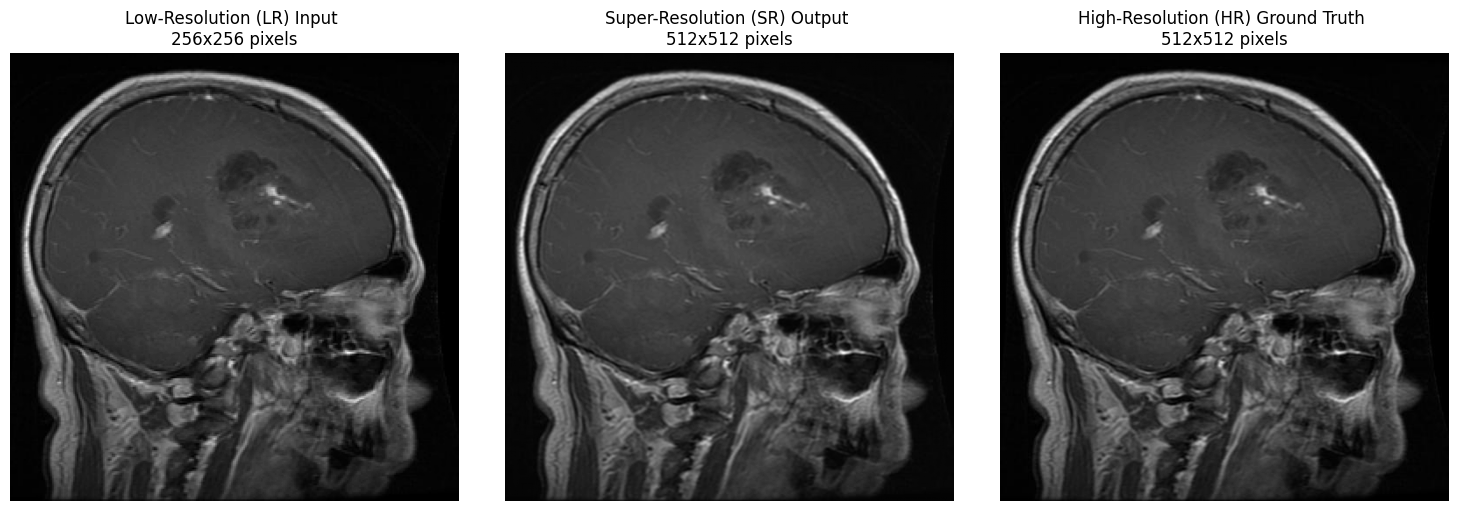

In [8]:
# Plot on graph
import matplotlib.pyplot as plt

lr_np = lr_img_1_x2
sr_np = sr_img_1_x2
hr_np = org_img_1

plt.figure(figsize=(15, 5))

# Low-Resolution Input
plt.subplot(1, 3, 1)
plt.title(f"Low-Resolution (LR) Input \n{lr_np.shape[1]}x{lr_np.shape[0]} pixels")
plt.xlabel(f"{lr_np.shape[1]}x{lr_np.shape[0]} pixels") # Note: assuming HxW for imshow
plt.imshow(lr_np, cmap='gray')
plt.axis('off') # Optional: turn off axes for cleaner image display

# Super-Resolution Output
plt.subplot(1, 3, 2)
plt.title(f"Super-Resolution (SR) Output \n{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.xlabel(f"{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.imshow(sr_np, cmap='gray')
plt.axis('off')

# High-Resolution Ground Truth
plt.subplot(1, 3, 3)
plt.title(f"High-Resolution (HR) Ground Truth \n{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.xlabel(f"{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.imshow(hr_np, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load x4 model
upscale = 4
srvit_model_x4 = load_model(upscale)
srvit_model_x4.eval()

lr_img_1_x4 = lr_img_1_x4.astype('float32') / 255.0
lr_img_2_x4 = lr_img_2_x4.astype('float32') / 255.0

lr_1_x4 = torch.from_numpy(lr_img_1_x4[np.newaxis, np.newaxis, :, :]).to(device)
lr_2_x4 = torch.from_numpy(lr_img_2_x4[np.newaxis, np.newaxis, :, :]).to(device)

# predict
with torch.no_grad():
    sr_1_x4 = srvit_model_x4(lr_1_x4)
    sr_2_x4 = srvit_model_x4(lr_2_x4)

sr_img_1_x4 = sr_1_x4.squeeze().cpu().numpy()
sr_img_2_x4 = sr_2_x4.squeeze().cpu().numpy()

print(f"Shape 1: {sr_img_1_x4.shape}")
print(f"Shape 2: {sr_img_2_x4.shape}")

Shape 1: (512, 512)
Shape 2: (512, 512)


In [10]:
# save and plot the images
cv2.imwrite(f'sr_x4_{img_1}.jpg', (sr_img_1_x4 * 255.0).astype(np.uint8))
cv2.imwrite(f'sr_x4_{img_2}.jpg', (sr_img_2_x4 * 255.0).astype(np.uint8))

True

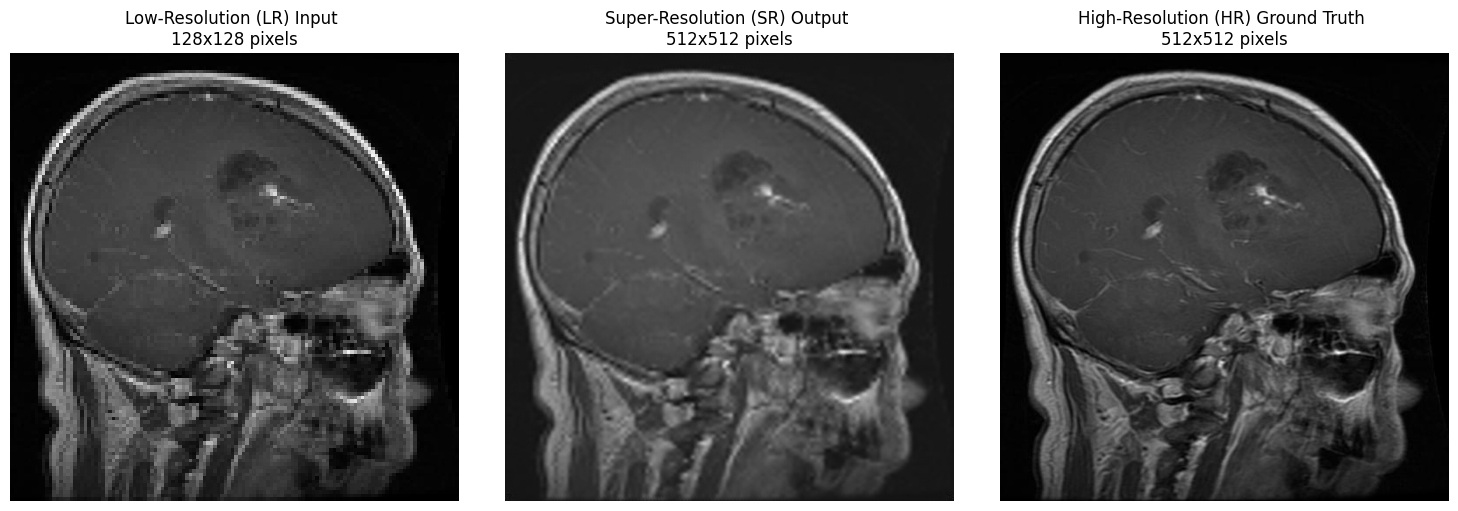

In [11]:
# Plot on graph
import matplotlib.pyplot as plt

lr_np = lr_img_1_x4
sr_np = sr_img_1_x4
hr_np = org_img_1

plt.figure(figsize=(15, 5))

# Low-Resolution Input
plt.subplot(1, 3, 1)
plt.title(f"Low-Resolution (LR) Input \n{lr_np.shape[1]}x{lr_np.shape[0]} pixels")
plt.xlabel(f"{lr_np.shape[1]}x{lr_np.shape[0]} pixels") # Note: assuming HxW for imshow
plt.imshow(lr_np, cmap='gray')
plt.axis('off') # Optional: turn off axes for cleaner image display

# Super-Resolution Output
plt.subplot(1, 3, 2)
plt.title(f"Super-Resolution (SR) Output \n{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.xlabel(f"{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.imshow(sr_np, cmap='gray')
plt.axis('off')

# High-Resolution Ground Truth
plt.subplot(1, 3, 3)
plt.title(f"High-Resolution (HR) Ground Truth \n{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.xlabel(f"{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.imshow(hr_np, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Super Resolution Convolutional Neural Network (SRCNN)

## SRCNN Utils

In [12]:
# Pre-process image for SRCNN model
def srcnn_preprocess(img_path, target_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Invalid Image Path")
        return
    hr_img = cv2.resize(img, (target_size, target_size))
    lr_img = cv2.resize(hr_img, (target_size // 2, target_size // 2), interpolation=cv2.INTER_CUBIC)
    lr_img = cv2.resize(lr_img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)

    return lr_img, hr_img, img

In [19]:
import tensorflow as tf

# load SRCNN model
def load_srcnn_model():
    model_path = "/kaggle/input/brain-tumor-mri-images/models/srcnn_final_model.keras"
    model = None
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"SRCNN model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading SRCNN model. {e}")
    return model

In [15]:
# get preprocessed images
srcnn_lr_img_1, srcnn_hr_img_1, srcnn_org_img_1 = srcnn_preprocess(img_path_1, 256)
srcnn_lr_img_2, srcnn_hr_img_2, srcnn_org_img_2 = srcnn_preprocess(img_path_2, 256)

print(f"1. LR shape: {srcnn_lr_img_1.shape}, HR shape: {srcnn_hr_img_1.shape}")
print(f"2. LR shape: {srcnn_lr_img_2.shape}, HR shape: {srcnn_hr_img_2.shape}")

# Save preprocessed images
cv2.imwrite(f"srcnn_lr_{img_1}.jpg", srcnn_lr_img_1)
cv2.imwrite(f"srcnn_lr_{img_2}.jpg", srcnn_lr_img_2)

1. LR shape: (256, 256), HR shape: (256, 256)
2. LR shape: (256, 256), HR shape: (256, 256)


True

In [21]:
# load model and predict SR images
srcnn_model = load_srcnn_model()

srcnn_lr_1 = (srcnn_lr_img_1.astype('float32') / 255.0)[:, :, np.newaxis]
srcnn_hr_1 = srcnn_hr_img_1.astype('float32') / 255.0

srcnn_lr_2 = (srcnn_lr_img_2.astype('float32') / 255.0)[:, :, np.newaxis]
srcnn_hr_2 = srcnn_hr_img_2.astype('float32') / 255.0

srcnn_sr_1 = srcnn_model.predict(srcnn_lr_1)
srcnn_sr_2 = srcnn_model.predict(srcnn_lr_2)

print(f'1. SR Shape: {srcnn_sr_1.shape}')
print(f'2. SR Shape: {srcnn_sr_2.shape}')

SRCNN model loaded successfully from /kaggle/input/brain-tumor-mri-images/models/srcnn_final_model.keras


I0000 00:00:1750397239.423415     112 service.cc:148] XLA service 0x77fcec00d160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750397239.424042     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750397239.424061     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750397239.491911     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1. SR Shape: (256, 256, 1, 1)
2. SR Shape: (256, 256, 1, 1)


I0000 00:00:1750397240.283365     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [23]:
# save sr images
srcnn_sr_img_1 = srcnn_sr_1.squeeze()
srcnn_sr_img_2 = srcnn_sr_2.squeeze()

print(f'1. SR Shape: {srcnn_sr_img_1.shape}')
print(f'2. SR Shape: {srcnn_sr_img_2.shape}')

cv2.imwrite(f"srcnn_sr_{img_1}.jpg", (srcnn_sr_img_1 * 255.0).astype(np.uint8))
cv2.imwrite(f"srcnn_sr_{img_2}.jpg", (srcnn_sr_img_2 * 255.0).astype(np.uint8))

1. SR Shape: (256, 256)
2. SR Shape: (256, 256)


True

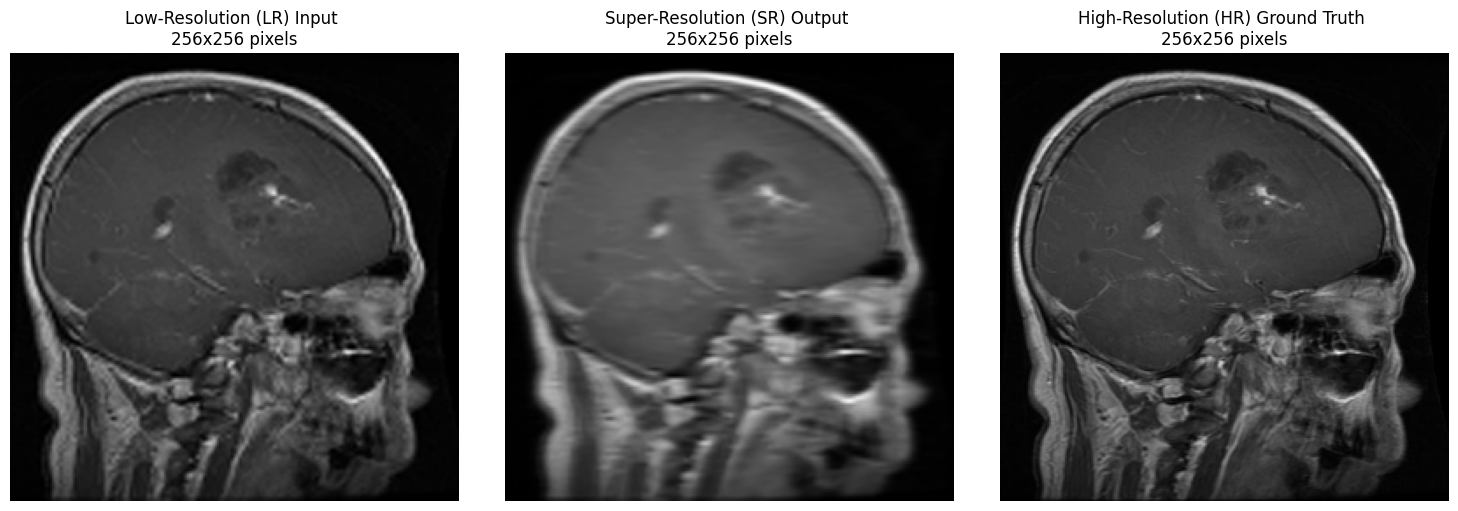

In [25]:
# Plot on graph
import matplotlib.pyplot as plt

lr_np = srcnn_lr_1.squeeze()
sr_np = srcnn_sr_img_1
hr_np = srcnn_hr_1

plt.figure(figsize=(15, 5))

# Low-Resolution Input
plt.subplot(1, 3, 1)
plt.title(f"Low-Resolution (LR) Input \n{lr_np.shape[1]}x{lr_np.shape[0]} pixels")
plt.xlabel(f"{lr_np.shape[1]}x{lr_np.shape[0]} pixels") # Note: assuming HxW for imshow
plt.imshow(lr_np, cmap='gray')
plt.axis('off') # Optional: turn off axes for cleaner image display

# Super-Resolution Output
plt.subplot(1, 3, 2)
plt.title(f"Super-Resolution (SR) Output \n{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.xlabel(f"{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
plt.imshow(sr_np, cmap='gray')
plt.axis('off')

# High-Resolution Ground Truth
plt.subplot(1, 3, 3)
plt.title(f"High-Resolution (HR) Ground Truth \n{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.xlabel(f"{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
plt.imshow(hr_np, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()